# Validating analytical predictions

In this section we show an example of validating some simple analytical predictions from coalescent theory using simulations. The number of segregating sites is the total number of mutations that occured in the history of the sample (assuming the infinite sites mutation model). Since mutations happen as a Poisson process along the branches of the tree, what we are really interested in is the distribution of the total branch length of the tree. The results in this section are well known classical results from coalescent theory; this section is intended as a demonstration of how one goes about comparing analytical results to simulations.


In [3]:
%matplotlib inline
import msprime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import binom


The first properties that we are interested in are the mean and the variance of the total branch length of coalescent trees. 

In [4]:
def T_total_mean(n):
    return 2 * np.sum(1 / np.arange(1, n))

def T_total_var(n):
    return 4 * np.sum(1 / np.arange(1, n)**2)

ns = np.array([5, 10, 15, 20, 25])
num_replicates = 1000
n_col = np.zeros(ns.shape[0] * num_replicates)
T_total_col = np.zeros(ns.shape[0] * num_replicates)
row = 0
for n in ns:
    for ts in msprime.simulate(n, Ne=0.5, num_replicates=num_replicates):
        tree = next(ts.trees())
        n_col[row] = n
        T_total_col[row] = tree.total_branch_length
        row += 1
df = pd.DataFrame({"n": n_col, "T_total": T_total_col})


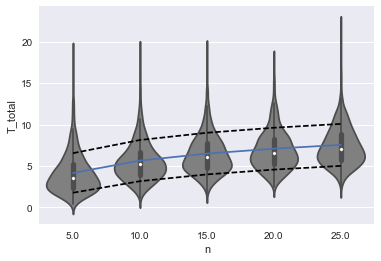

In [13]:
mean_T = np.array([T_total_mean(n) for n in ns])
var_T = np.sqrt(np.array([T_total_var(n) for n in ns]))
ax = sns.violinplot(x="n", y="T_total", data=df, color="grey")
ax.plot(mean_T, "-");
ax.plot(mean_T - var_T, "--", color="black");
ax.plot(mean_T + var_T, "--", color="black");


This plot shows the simulated distribution of the total branch lengths over replicate simulations (each violin is a distribution for a given sample size). We also show our analytical prediction for the mean and variance of each distrubution (the dashed lines show +/- one standard deviation from the mean). We can see that these one-dimensional summaries of the distrubution do capture some essential properties, but we lose some important aspects of the distrubution. 


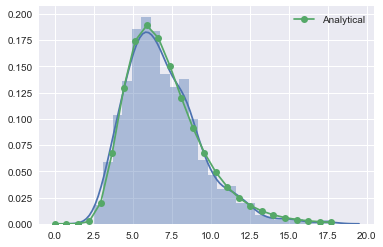

In [20]:
def T_total_density(n, t):
    e_t2 = np.exp(-t / 2)
    return 0.5 * (n - 1) * e_t2 * (1 - e_t2)**(n - 2) 

n = 20
T_total_20 = T_total_col[n_col == n]
ts = np.linspace(0, np.max(T_total_20), 25)
t_densities = np.array([T_total_density(n, t) for t in ts])
sns.distplot(T_total_20)
plt.plot(ts, t_densities, marker="o", label="Analytical")
plt.legend();


Ideally, we wish to capture the full complexity of the distribution as an analytical value. Here we plot the full distribution for the total tree length with a sample of size 20, along with the empirical prediction. We can see an excellent agreement between smoothed kernel density esimate produced by Seaborn and our analytically computed value.

We cannot directly observe branch lenghts, and so we are usually more interested in mutations when working with data. The mutation process is intimately related to the distrubution of branch lengths, since mutations occur randomly along tree branches. One simple summary of the mutational process is the number of observed segregating sites, or the  number of sites at which we observe variation. We can obtain this information very easily from simulations simply by specifying a mutation rate parameter.

In [6]:
def S_dist(n, theta, k):
    S = 0
    for i in range(2, n + 1):
        S += ((-1)**i * binom(n - 1, i - 1) 
              * (i - 1) / (theta + i - 1) * (theta / (theta + i - 1))**k)
    return S

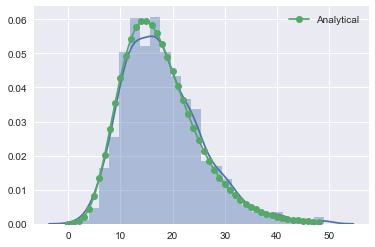

In [35]:
n = 20
theta = 5
num_replicates = 1000
simulation = np.zeros(num_replicates)
replicates = msprime.simulate(
    n, mutation_rate=theta / 4, num_replicates=num_replicates)
for j, ts in enumerate(replicates):
    simulation[j] = ts.num_sites  # number of seg. sites
ks = np.arange(np.max(simulation))
analytical = np.array([S_dist(n, theta, k) for k in ks])

sns.distplot(simulation) 
plt.plot(ks, analytical, marker='o', label="Analytical")
plt.legend();


Here we take 1000 replicate simulations, store the number of infinite sites mutations for each one and then plot this distrubution. We also plot analytical prediction, and see an excellent fit.